In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip, Activation

In [ ]:
def load_and_split_data(data_dir, test_size, val_size):
    classes = os.listdir(data_dir)
    num_classes = len(classes)
    X, y = [], []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            img = load_img(os.path.join(class_dir, filename), target_size=(210, 210))
            img_array = img_to_array(img)
            X.append(img_array)
            y.append(i)

    X = np.array(X) / 255.0  # rescale data dengan min-max normalization
    y = np.array(y)

    # Split data menjadi train dan temporary (test + validation)
    X_train_temp, X_test_val, y_train_temp, y_test_val = train_test_split(X, y, test_size=(test_size + val_size), random_state=42)

    # Split temporary data menjadi test dan validation
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=val_size/(test_size + val_size), random_state=42)

    # Menambahkan satu dimensi untuk grayscale image
    if len(X_train_temp.shape) == 3:
        X_train_temp = np.expand_dims(X_train_temp, axis=-1)
        X_test = np.expand_dims(X_test, axis=-1)
        X_val = np.expand_dims(X_val, axis=-1)

    return X_train_temp, X_test, X_val, y_train_temp, y_test, y_val, num_classes, classes

# Penggunaan fungsi
data_dir = '/content/drive/MyDrive/ColabNotebooks/cnn_series/coffee_bean/dataset/prepro-2'
test_size = 0.2  # Ubah sesuai kebutuhan, misalnya 0.2 untuk 20% data dijadikan test
val_size = 0.2  # Ubah sesuai kebutuhan, misalnya 0.2 untuk 20% data dijadikan validation

X_train, X_test, X_val, y_train, y_test, y_val, num_classes, classes = load_and_split_data(data_dir, test_size, val_size)

print("Jumlah data train:", X_train.shape[0])
print("Jumlah data test:", X_test.shape[0])
print("Jumlah data validation:", X_val.shape[0])
print("Jumlah kelas:", num_classes)
print("Daftar kelas:", classes)

Jumlah data train: 1779
Jumlah data test: 593
Jumlah data validation: 593
Jumlah kelas: 3
Daftar kelas: ['Dark', 'Medium', 'Light']


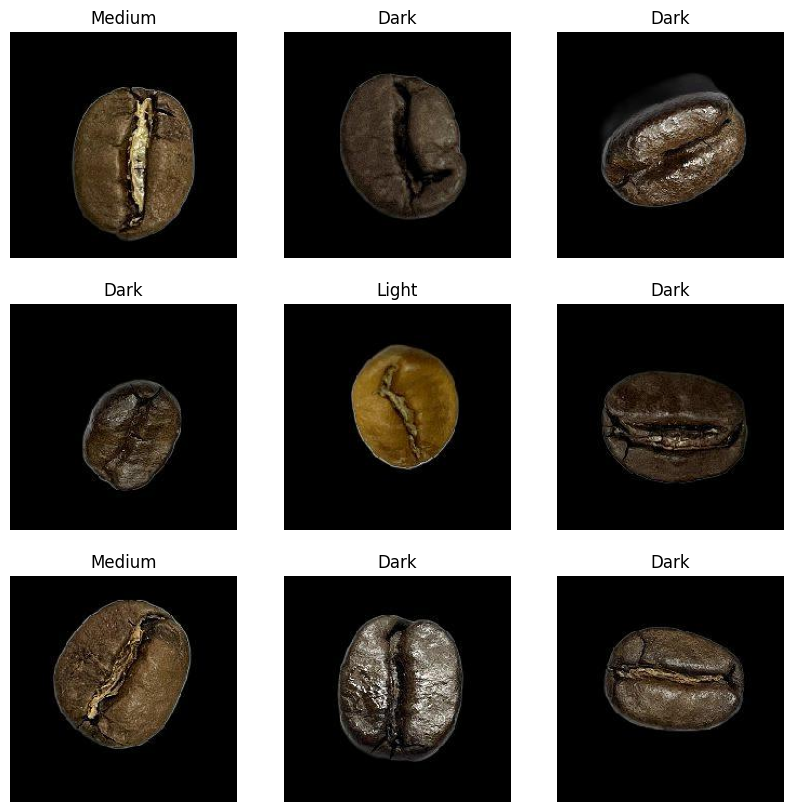

In [ ]:
def plot_samples(X, y, classes):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i])
        ax.set_title(classes[y[i]])
        ax.axis('off')
    plt.show()

plot_samples(X_train, y_train, classes)

In [ ]:
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
# Define the hyperparameters
input_shape = (210, 210, 3) # Image size
batch_size = 32
epochs = 30
learning_rate = 0.001
num_classes = 3 # Number of classes in the dataset

In [ ]:
#Building model 1 using customized convolutional and pooling layers

# Reference: Jurnal Buah Zaitun

# Building the model
model = Sequential()
# 3 convolutional layers
model.add(Conv2D(64, (5, 5), input_shape=input_shape, strides=2, padding="same", activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(256, (3, 3), strides=1, padding="same", activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.2))

# 2 hidden layers
model.add(Flatten())
model.add(Dense(256, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation= 'relu'))

# The output layer with 4 neurons, for 4 classes
model.add(Dense(3 , activation= 'softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 105, 105, 64)      4864      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 52, 52, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 26, 26, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 13, 13, 128)    

In [ ]:
import tensorflow as tf

# Compiling the CNN
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Define callbacks for early stopping and saving the best model
# early_stop = EarlyStopping(patience=15, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/ColabNotebooks/cnn_series/coffee_bean/best model/Coba_2/b32_e30_lr001.h5', save_best_only=True, verbose=1)

In [ ]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[model_checkpoint], validation_data=(X_val, y_val))

Epoch 1/30
55/56 [============================>.] - ETA: 0s - loss: 0.7345 - accuracy: 0.6602
Epoch 1: val_loss improved from inf to 0.33713, saving model to /content/drive/MyDrive/ColabNotebooks/cnn_series/coffee_bean/best model/Coba_2/b32_e30_lr001.h5
56/56 [==============================] - 10s 133ms/step - loss: 0.7284 - accuracy: 0.6639 - val_loss: 0.3371 - val_accuracy: 0.8735
Epoch 2/30
55/56 [============================>.] - ETA: 0s - loss: 0.2678 - accuracy: 0.9119
Epoch 2: val_loss improved from 0.33713 to 0.08997, saving model to /content/drive/MyDrive/ColabNotebooks/cnn_series/coffee_bean/best model/Coba_2/b32_e30_lr001.h5
56/56 [==============================] - 2s 42ms/step - loss: 0.2659 - accuracy: 0.9123 - val_loss: 0.0900 - val_accuracy: 0.9730
Epoch 3/30
55/56 [============================>.] - ETA: 0s - loss: 0.1621 - accuracy: 0.9403
Epoch 3: val_loss did not improve from 0.08997
56/56 [==============================] - 2s 37ms/step - loss: 0.1607 - accuracy: 0.94

In [ ]:
# def plot_history(history):
#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'], label='Training Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#     plt.legend()
#     plt.title('Training and Validation Accuracy')

#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'], label='Training Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.legend()
#     plt.title('Training and Validation Loss')

#     plt.show()

#     # Dapatkan nilai akurasi tertinggi dan loss terendah
#     max_accuracy = max(history.history['accuracy'])
#     min_loss = min(history.history['loss'])
#     print(f"\nAkurasi training tertinggi: {max_accuracy:.4f}")
#     print(f"Loss training terendah: {min_loss:.4f}")

#     # Dapatkan nilai akurasi tertinggi dan loss terendah
#     max_accuracy = max(history.history['val_accuracy'])
#     min_loss = min(history.history['val_loss'])
#     print(f"\nAkurasi tertinggi: {max_accuracy:.4f}")
#     print(f"Loss terendah: {min_loss:.4f}")

# plot_history(history)

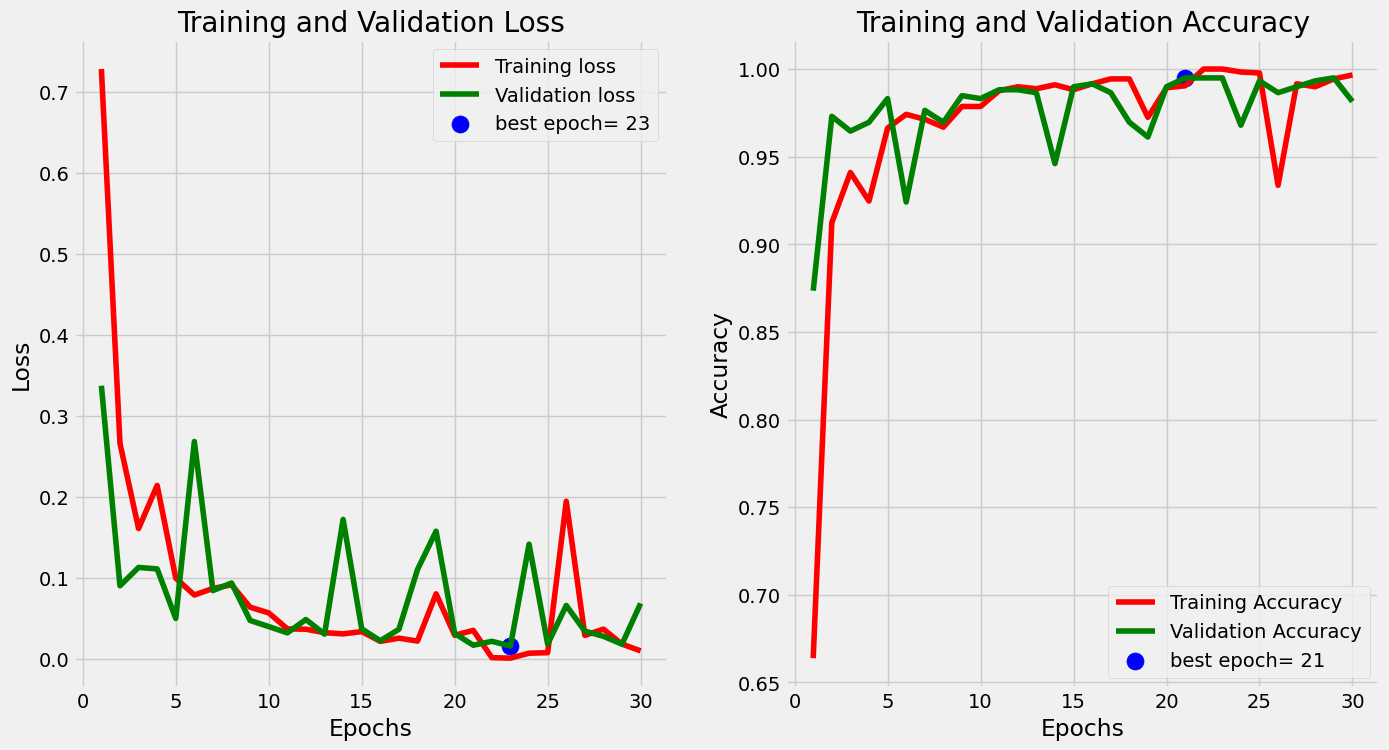


Akurasi training tertinggi: 1.0000
Loss training terendah: 0.0006

Akurasi tertinggi: 0.9949
Loss terendah: 0.0155


In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

    # Dapatkan nilai akurasi tertinggi dan loss terendah
    max_accuracy = max(history.history['accuracy'])
    min_loss = min(history.history['loss'])
    print(f"\nAkurasi training tertinggi: {max_accuracy:.4f}")
    print(f"Loss training terendah: {min_loss:.4f}")

    # Dapatkan nilai akurasi tertinggi dan loss terendah
    max_accuracy = max(history.history['val_accuracy'])
    min_loss = min(history.history['val_loss'])
    print(f"\nAkurasi tertinggi: {max_accuracy:.4f}")
    print(f"Loss terendah: {min_loss:.4f}")

tr_plot(history,0)

In [ ]:
from sklearn.metrics import confusion_matrix

pre = model.predict(X_test)

# Assuming y_test and pre are in one-hot encoded format
y_test_labels = np.argmax(y_test, axis=1)
pre_labels = np.argmax(pre, axis=1)

# Now you can compute the confusion matrix
cm = confusion_matrix(y_test_labels, pre_labels)
print(cm)

19/19 [==============================] - 0s 15ms/step
[[228  12   0]
 [  0 183   3]
 [  0   0 167]]


              precision    recall  f1-score   support

        Dark       1.00      0.95      0.97       240
      Medium       0.94      0.98      0.96       186
       Light       0.98      1.00      0.99       167

    accuracy                           0.97       593
   macro avg       0.97      0.98      0.98       593
weighted avg       0.98      0.97      0.97       593



<Axes: >

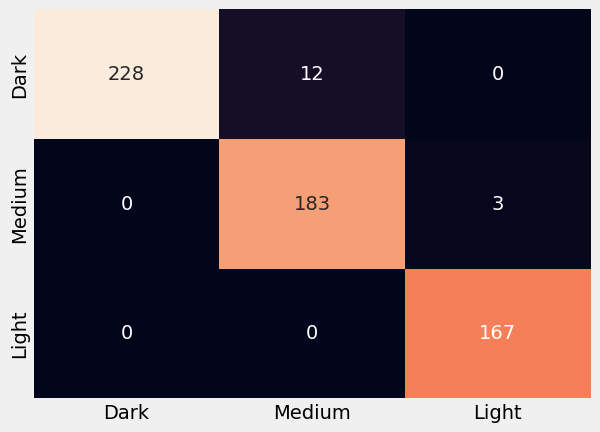

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report

print(classification_report(y_test_labels, pre_labels, target_names=classes))
sns.heatmap(cm, xticklabels=classes, yticklabels=classes, annot=True, cbar=False, fmt='g')

In [ ]:
from tensorflow.keras.preprocessing import image
from skimage.io import imread
from skimage.transform import resize

def predict_image(image_path):
    img = imread(image_path)
    img = resize(img, (210,210))

    img = image.img_to_array(img)
    plt.imshow(img)
    plt.show()
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    prediction = np.argmax(preds)
    pct = np.max(preds)
    if prediction == 0:
        print('Dark')
    elif prediction == 1:
        print('Medium')
    elif prediction == 2:
        print('Light')

    print(pct)
    print(prediction)

Notes:
- Can't detect **Light Coffe Bean** except pic number (20)

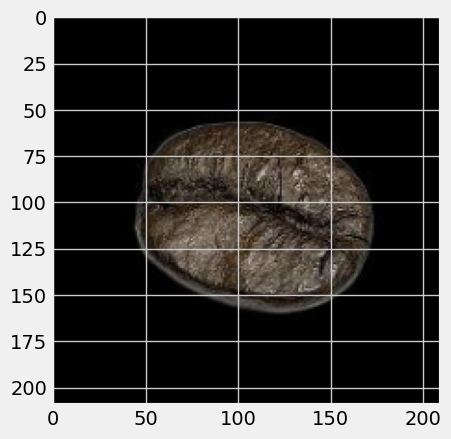

1/1 [==============================] - 0s 20ms/step
Dark
0.9999093
0


In [ ]:
path = "/content/drive/MyDrive/ColabNotebooks/cnn_series/coffee_bean/dataset/prepro-2/Dark/Dark_1800.jpg"
predict_image(path)